In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Load NVIDIA stock data from Yahoo Finance
nvidia = yf.download('NVDA', start='2018-01-01', end='2024-01-01', interval='1d')
nvidia.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,4.89450,4.98750,4.86250,4.98375,4.930644,355616000
2018-01-03,5.10250,5.34250,5.09375,5.31175,5.255147,914704000
2018-01-04,5.39400,5.45125,5.31725,5.33975,5.282849,583268000
2018-01-05,5.35475,5.42275,5.27700,5.38500,5.327616,580124000
2018-01-08,5.51000,5.62500,5.46450,5.55000,5.490858,881216000


In [27]:
# Define technical indicator functions
def moving_average(df, window):
    return df['Close'].rolling(window=window).mean()

def exponential_moving_average(df, window):
    return df['Close'].ewm(span=window, adjust=False).mean()

def momentum(df, window):
    return df['Close'].diff(window)

def rsi(df, window):
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))


In [28]:
# Calculate technical indicators
nvidia['SMA10'] = moving_average(nvidia, 10)
nvidia['SMA60'] = moving_average(nvidia, 60)
nvidia['EMA10'] = exponential_moving_average(nvidia, 10)
nvidia['EMA20'] = exponential_moving_average(nvidia, 20)
nvidia['EMA50'] = exponential_moving_average(nvidia, 50)
nvidia['Momentum'] = momentum(nvidia, 10)
nvidia['RSI'] = rsi(nvidia, 14)

# Drop NaN values
nvidia.dropna(inplace=True)
nvidia.head()


,Open,High,Low,Close,Adj Close,Volume,SMA10,SMA60,EMA10,EMA20,EMA50,Momentum,RSI
Date,,,,,,,,,,,,,
2018-03-28,5.60325,5.73475,5.42500,5.53375,5.478183,945904000,6.012825,5.875833,5.921635,5.986501,5.879645,-0.68475,38.012331
2018-03-29,5.60275,5.88750,5.51750,5.78975,5.731613,916628000,5.968450,5.889267,5.897656,5.967763,5.876120,-0.44375,42.263508
2018-04-02,5.71850,5.86625,5.43750,5.52625,5.470759,922092000,5.894875,5.892842,5.830128,5.925714,5.862400,-0.73575,34.875142
2018-04-03,5.69500,5.75875,5.53375,5.63375,5.577180,667432000,5.855750,5.897742,5.794423,5.897908,5.853433,-0.39125,38.493206
2018-04-04,5.37525,5.66650,5.35000,5.65600,5.599206,789168000,5.797400,5.902258,5.769255,5.874869,5.845691,-0.58350,38.404452


# Simple EMA 12 - EMA 26 crossover strategy

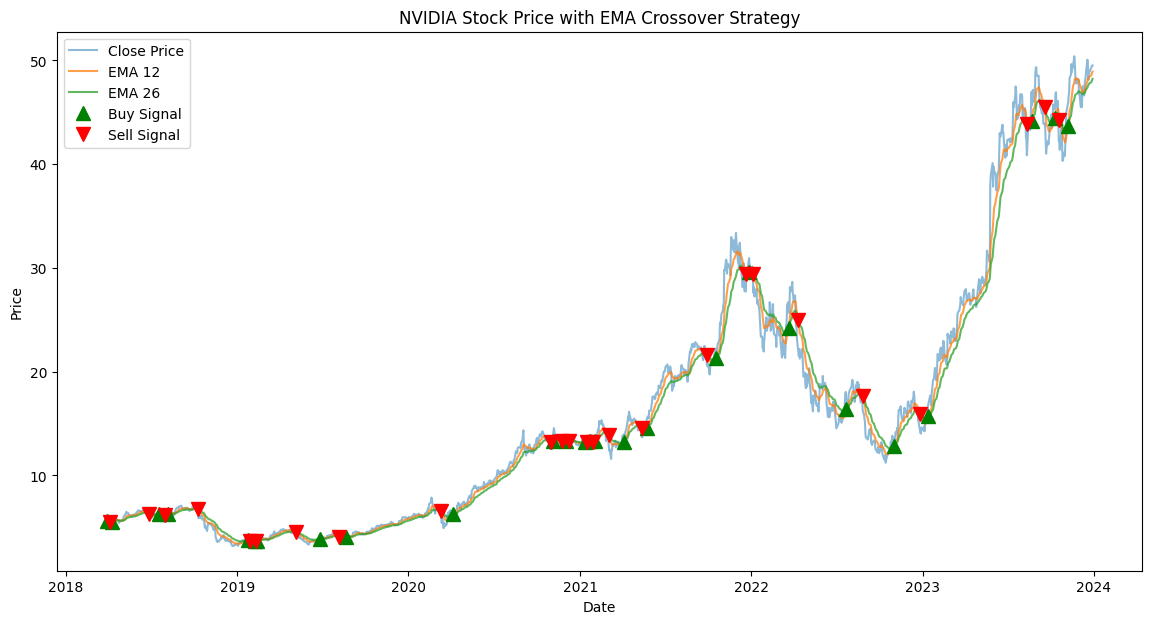

In [29]:
# EMA crossover strategy
short_window = 12
long_window = 26

# Calculate the EMAs
nvidia['EMA12'] = nvidia['Close'].ewm(span=short_window, adjust=False).mean()
nvidia['EMA26'] = nvidia['Close'].ewm(span=long_window, adjust=False).mean()

# Initialize signals
nvidia['Signal'] = np.where(nvidia['EMA12'] > nvidia['EMA26'], 1, 0)
nvidia['Position'] = nvidia['Signal'].diff()

# Visualize signals
plt.figure(figsize=(14, 7))
plt.plot(nvidia['Close'], label='Close Price', alpha=0.5)
plt.plot(nvidia['EMA12'], label='EMA 12', alpha=0.75)
plt.plot(nvidia['EMA26'], label='EMA 26', alpha=0.75)
plt.plot(nvidia[nvidia['Position'] == 1].index, nvidia['EMA12'][nvidia['Position'] == 1], '^', markersize=10, color='g', label='Buy Signal')
plt.plot(nvidia[nvidia['Position'] == -1].index, nvidia['EMA12'][nvidia['Position'] == -1], 'v', markersize=10, color='r', label='Sell Signal')
plt.title('NVIDIA Stock Price with EMA Crossover Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


EMA Crossover Sharpe Ratio: 0.82
EMA Crossover Annualized Sharpe Ratio: 0.82


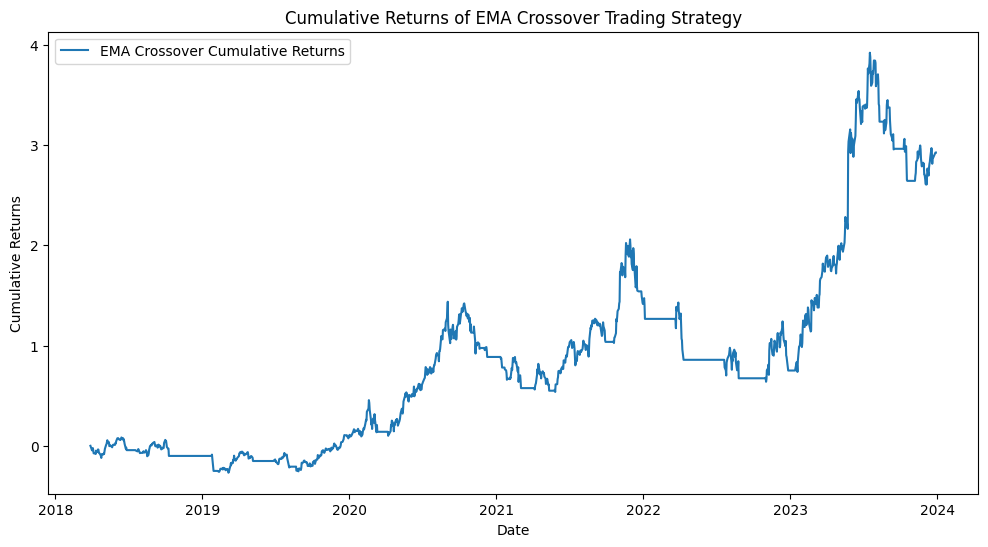

In [30]:
# Function to calculate performance metrics
def calculate_performance_metrics(df, signal_col):
    df['returns'] = df['Close'].pct_change()
    df['strategy_returns'] = df[signal_col].shift(1) * df['returns']
    cumulative_returns = (1 + df['strategy_returns']).cumprod() - 1

    sharpe_ratio = (df['strategy_returns'].mean() / df['strategy_returns'].std()) * np.sqrt(252)
    annualized_return = df['strategy_returns'].mean() * 252
    annualized_volatility = df['strategy_returns'].std() * np.sqrt(252)
    annualized_sharpe_ratio = annualized_return / annualized_volatility

    return cumulative_returns, sharpe_ratio, annualized_sharpe_ratio

# Calculate cumulative returns and performance metrics for EMA crossover strategy
ema_cumulative_returns, ema_sharpe_ratio, ema_annualized_sharpe_ratio = calculate_performance_metrics(nvidia, 'Signal')

# Print performance metrics for EMA crossover strategy
print(f"EMA Crossover Sharpe Ratio: {ema_sharpe_ratio:.2f}")
print(f"EMA Crossover Annualized Sharpe Ratio: {ema_annualized_sharpe_ratio:.2f}")

# Plot cumulative returns for EMA crossover strategy
plt.figure(figsize=(12, 6))
plt.plot(ema_cumulative_returns, label='EMA Crossover Cumulative Returns')
plt.title('Cumulative Returns of EMA Crossover Trading Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


# Machine Learning Strategy using Technical Indicators as Features

In [31]:
def bollinger_bands(df, window=20):
    rolling_mean = df['Close'].rolling(window).mean()
    rolling_std = df['Close'].rolling(window).std()
    df['Bollinger_High'] = rolling_mean + (rolling_std * 2)
    df['Bollinger_Low'] = rolling_mean - (rolling_std * 2)
    return df

nvidia = bollinger_bands(nvidia)

def macd(df, short_window=12, long_window=26, signal_window=9):
    df['MACD'] = df['Close'].ewm(span=short_window, adjust=False).mean() - df['Close'].ewm(span=long_window, adjust=False).mean()
    df['MACD_Signal'] = df['MACD'].ewm(span=signal_window, adjust=False).mean()
    return df

nvidia = macd(nvidia)

def stochastic_oscillator(df, window=14):
    df['Lowest_Low'] = df['Low'].rolling(window=window).min()
    df['Highest_High'] = df['High'].rolling(window=window).max()
    df['Stochastic_Oscillator'] = ((df['Close'] - df['Lowest_Low']) / (df['Highest_High'] - df['Lowest_Low'])) * 100
    return df

nvidia = stochastic_oscillator(nvidia)

def average_true_range(df, window=14):
    df['High-Low'] = df['High'] - df['Low']
    df['High-Close'] = np.abs(df['High'] - df['Close'].shift())
    df['Low-Close'] = np.abs(df['Low'] - df['Close'].shift())
    df['True_Range'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    df['ATR'] = df['True_Range'].rolling(window=window).mean()
    return df

nvidia = average_true_range(nvidia)

def on_balance_volume(df):
    df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    return df

nvidia = on_balance_volume(nvidia)



In [32]:
# Adding lag features
for lag in range(1, 6):  # Create lag features for the past 5 days
    nvidia[f'Lag_{lag}'] = nvidia['Close'].shift(lag)

# Drop NaN values after adding lag features
nvidia.dropna(inplace=True)

# Update the feature set to include the lag features
features = ['SMA10', 'SMA60', 'EMA10', 'EMA20', 'EMA50', 'Momentum', 'RSI'] + [f'Lag_{lag}' for lag in range(1, 6)]
X = nvidia[features]
y = nvidia['Signal']

In [33]:
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)


In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid with more regularization
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6]
}

# Initialize RandomForestClassifier
rf_model = RandomForestClassifier()

# Perform Grid Search with cross-validation
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

# Best parameters and model
best_rf_model = grid_search_rf.best_estimator_
print("Best parameters for RandomForest:", grid_search_rf.best_params_)

# Predictions with the best RandomForest model
rf_predictions = best_rf_model.predict(X_test)
print(f"RandomForest - Training Accuracy: {best_rf_model.score(X_train, y_train):.2f}, Testing Accuracy: {best_rf_model.score(X_test, y_test):.2f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for RandomForest: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
RandomForest - Training Accuracy: 0.99, Testing Accuracy: 0.84


In [35]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid with regularization
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'reg_alpha': [0, 0.01, 0.1],  # L1 regularization term on weights
    'reg_lambda': [1, 1.5, 2]  # L2 regularization term on weights
}

# Initialize XGBClassifier
xgb_model = XGBClassifier(eval_metric='logloss')

# Perform Grid Search with cross-validation
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)

# Best parameters and model
best_xgb_model = grid_search_xgb.best_estimator_
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)

# Predictions with the best XGBoost model
xgb_predictions = best_xgb_model.predict(X_test)
print(f"XGBoost - Training Accuracy: {best_xgb_model.score(X_train, y_train):.2f}, Testing Accuracy: {best_xgb_model.score(X_test, y_test):.2f}")

Fitting 5 folds for each of 972 candidates, totalling 4860 fits
Best parameters for XGBoost: {'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 150, 'reg_alpha': 0.1, 'reg_lambda': 1.5, 'subsample': 0.8}
XGBoost - Training Accuracy: 1.00, Testing Accuracy: 0.91


RandomForest Sharpe Ratio: 2.31
RandomForest Annualized Sharpe Ratio: 2.31
XGBoost Sharpe Ratio: 2.02
XGBoost Annualized Sharpe Ratio: 2.02


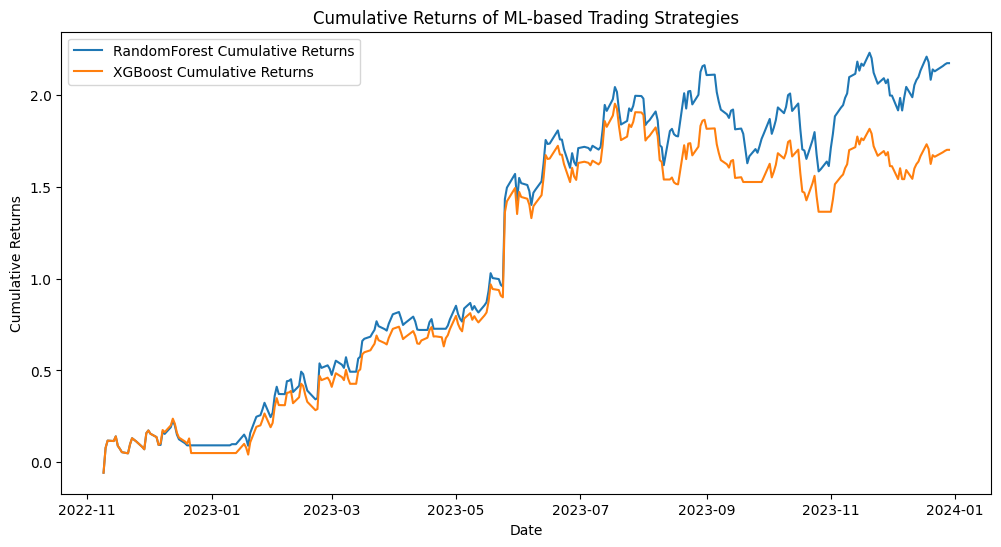

In [36]:
# Ensure the indices of test_df and X_test align correctly
test_df = nvidia.iloc[len(X_train):].copy()

# Add the predictions from the best models to the test dataframe
test_df['rf_signal'] = rf_predictions
test_df['xgb_signal'] = xgb_predictions

# Function to calculate performance metrics
def calculate_performance(df, signal_col):
    df['returns'] = df['Close'].pct_change()
    df['strategy_returns'] = df[signal_col].shift(1) * df['returns']
    cumulative_returns = (1 + df['strategy_returns']).cumprod() - 1

    sharpe_ratio = (df['strategy_returns'].mean() / df['strategy_returns'].std()) * np.sqrt(252)
    annualized_return = df['strategy_returns'].mean() * 252
    annualized_volatility = df['strategy_returns'].std() * np.sqrt(252)
    annualized_sharpe_ratio = annualized_return / annualized_volatility

    return cumulative_returns, sharpe_ratio, annualized_sharpe_ratio

# Calculate performance for RandomForest strategy
rf_cumulative_returns, rf_sharpe_ratio, rf_annualized_sharpe_ratio = calculate_performance(test_df, 'rf_signal')

# Calculate performance for XGBoost strategy
xgb_cumulative_returns, xgb_sharpe_ratio, xgb_annualized_sharpe_ratio = calculate_performance(test_df, 'xgb_signal')

# Print performance metrics
print(f"RandomForest Sharpe Ratio: {rf_sharpe_ratio:.2f}")
print(f"RandomForest Annualized Sharpe Ratio: {rf_annualized_sharpe_ratio:.2f}")
print(f"XGBoost Sharpe Ratio: {xgb_sharpe_ratio:.2f}")
print(f"XGBoost Annualized Sharpe Ratio: {xgb_annualized_sharpe_ratio:.2f}")

# Plot cumulative returns for both strategies
plt.figure(figsize=(12, 6))
plt.plot(rf_cumulative_returns, label='RandomForest Cumulative Returns')
plt.plot(xgb_cumulative_returns, label='XGBoost Cumulative Returns')
plt.title('Cumulative Returns of ML-based Trading Strategies')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()


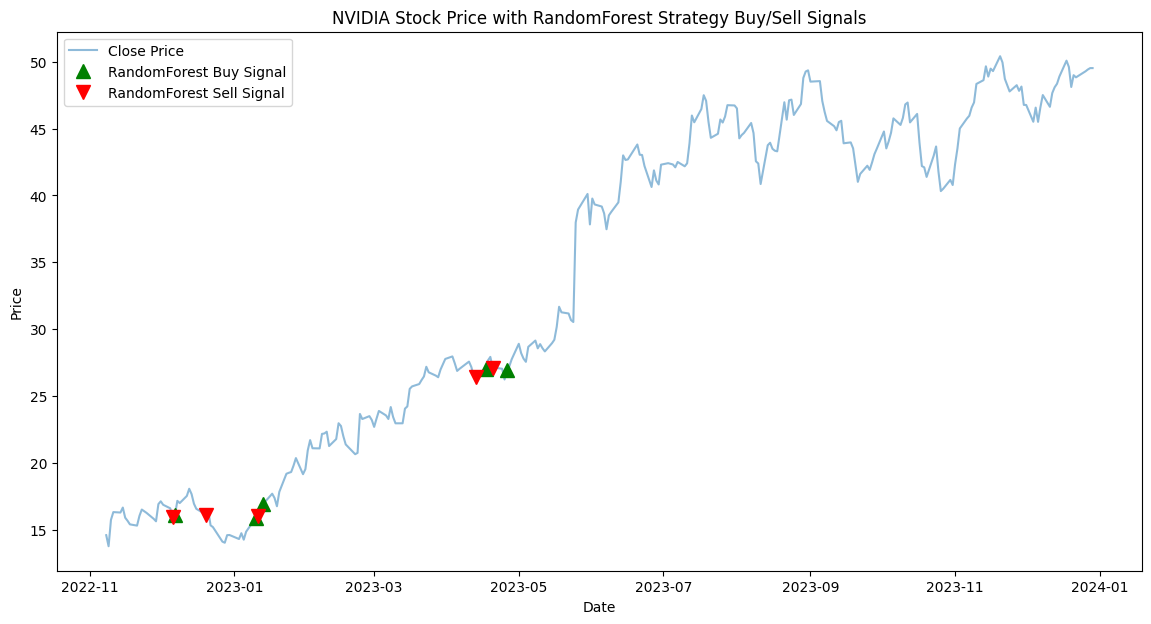

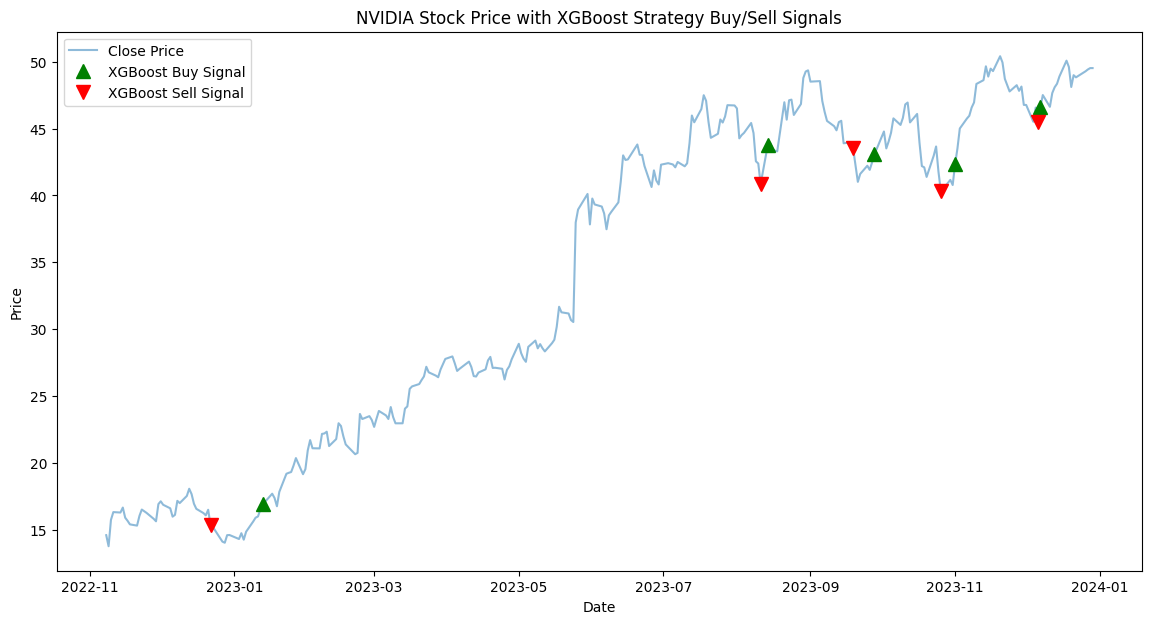

In [37]:
# Calculate positions for RandomForest and XGBoost strategies
test_df['rf_position'] = test_df['rf_signal'].diff()
test_df['xgb_position'] = test_df['xgb_signal'].diff()

# Plot cumulative returns and buy/sell signals for RandomForest strategy
plt.figure(figsize=(14, 7))
plt.plot(test_df['Close'], label='Close Price', alpha=0.5)
plt.plot(test_df['Close'][test_df['rf_position'] == 1], '^', markersize=10, color='g', label='RandomForest Buy Signal')
plt.plot(test_df['Close'][test_df['rf_position'] == -1], 'v', markersize=10, color='r', label='RandomForest Sell Signal')
plt.title('NVIDIA Stock Price with RandomForest Strategy Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot cumulative returns and buy/sell signals for XGBoost strategy
plt.figure(figsize=(14, 7))
plt.plot(test_df['Close'], label='Close Price', alpha=0.5)
plt.plot(test_df['Close'][test_df['xgb_position'] == 1], '^', markersize=10, color='g', label='XGBoost Buy Signal')
plt.plot(test_df['Close'][test_df['xgb_position'] == -1], 'v', markersize=10, color='r', label='XGBoost Sell Signal')
plt.title('NVIDIA Stock Price with XGBoost Strategy Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [38]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation for RandomForest
rf_cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5)
print(f"RandomForest Cross-Validation Scores: {rf_cv_scores}")
print(f"RandomForest Mean CV Score: {rf_cv_scores.mean():.2f}")

# Perform cross-validation for XGBoost
xgb_cv_scores = cross_val_score(best_xgb_model, X_train, y_train, cv=5)
print(f"XGBoost Cross-Validation Scores: {xgb_cv_scores}")
print(f"XGBoost Mean CV Score: {xgb_cv_scores.mean():.2f}")

RandomForest Cross-Validation Scores: [0.81659389 0.82532751 0.62882096 0.43231441 0.43421053]
RandomForest Mean CV Score: 0.63
XGBoost Cross-Validation Scores: [0.82969432 0.83406114 0.65938865 0.59825328 0.53070175]
XGBoost Mean CV Score: 0.69


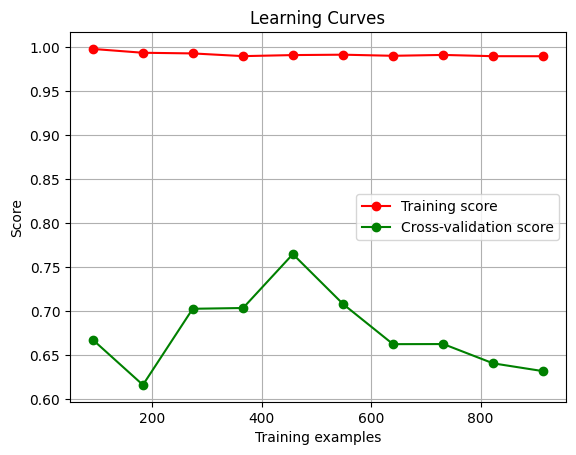

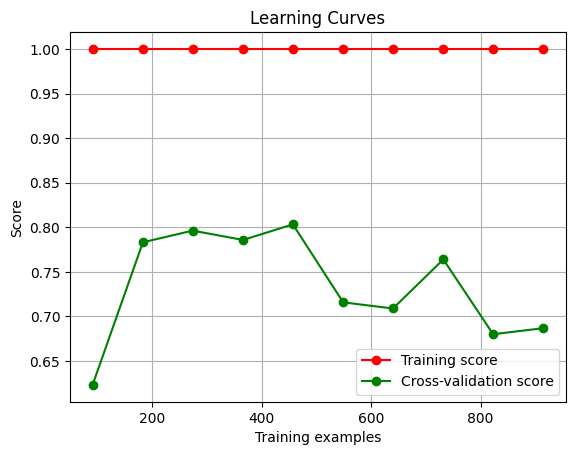

In [39]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.title('Learning Curves')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Plot learning curve for RandomForest
plot_learning_curve(best_rf_model, X_train, y_train)

# Plot learning curve for XGBoost
plot_learning_curve(best_xgb_model, X_train, y_train)


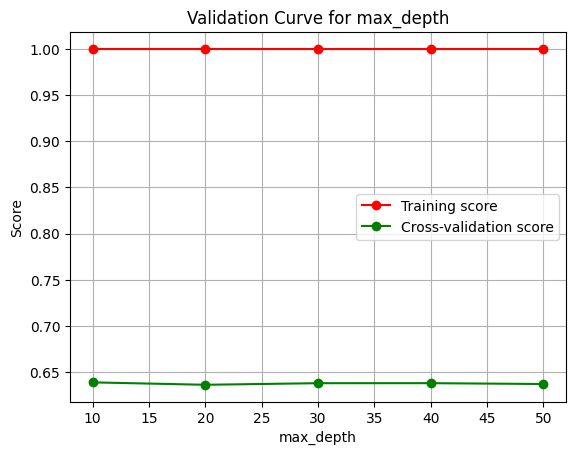

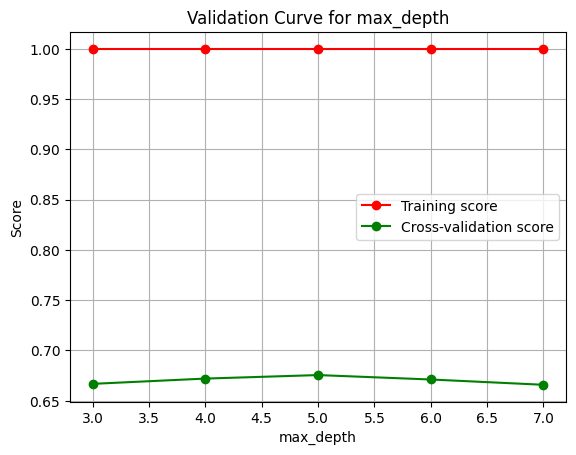

In [40]:
from sklearn.model_selection import validation_curve

def plot_validation_curve(estimator, X, y, param_name, param_range, cv=5):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range, cv=cv, n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure()
    plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(param_range, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.title(f'Validation Curve for {param_name}')
    plt.xlabel(f'{param_name}')
    plt.ylabel('Score')
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Validation curve for max_depth in RandomForest
plot_validation_curve(RandomForestClassifier(), X_train, y_train, 'max_depth', [10, 20, 30, 40, 50])

# Validation curve for max_depth in XGBoost
plot_validation_curve(XGBClassifier(), X_train, y_train, 'max_depth', [3, 4, 5, 6, 7])

Feature ranking:
1. Feature RSI (0.2564)
2. Feature Momentum (0.1565)
3. Feature SMA60 (0.1165)
4. Feature EMA50 (0.0822)
5. Feature Lag_1 (0.0762)
6. Feature EMA10 (0.0659)
7. Feature Lag_2 (0.0588)
8. Feature SMA10 (0.0492)
9. Feature EMA20 (0.0472)
10. Feature Lag_3 (0.0399)
11. Feature Lag_4 (0.0304)
12. Feature Lag_5 (0.0208)


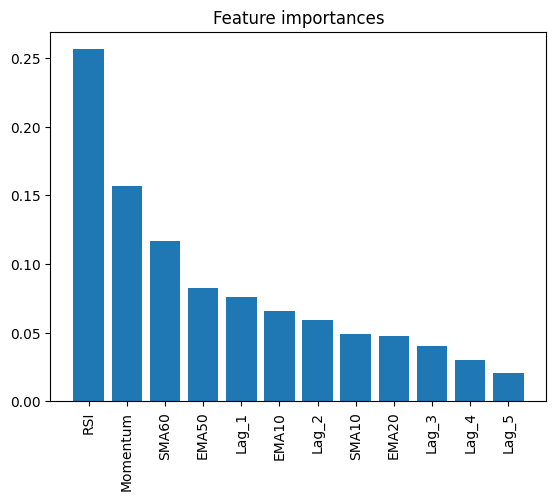

In [41]:
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Get feature names
feature_names = X.columns

# Print feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. Feature {feature_names[indices[f]]} ({importances[indices[f]]:.4f})")

# Plot the feature importances
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [42]:
train_accuracy_rf = best_rf_model.score(X_train, y_train)
test_accuracy_rf = best_rf_model.score(X_test, y_test)

train_accuracy_xgb = best_xgb_model.score(X_train, y_train)
test_accuracy_xgb = best_xgb_model.score(X_test, y_test)

print(f"RandomForest - Training Accuracy: {train_accuracy_rf:.2f}, Testing Accuracy: {test_accuracy_rf:.2f}")
print(f"XGBoost - Training Accuracy: {train_accuracy_xgb:.2f}, Testing Accuracy: {test_accuracy_xgb:.2f}")

RandomForest - Training Accuracy: 0.99, Testing Accuracy: 0.84
XGBoost - Training Accuracy: 1.00, Testing Accuracy: 0.91
